In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

KeyboardInterrupt: 

In [3]:
import child_poverty_iraq.data.load_data as ld
import pandas as pd

In [7]:
import geopandas as gpd

In [11]:
geom_adm0 = ld.get_mosaiks_geom_adm0()

irq_adm0 = geom_adm0[geom_adm0['shapeISO']=='IRQ']

The file '../data/external/geoBoundariesCGAZ_ADM0.topojson' exists.


In [8]:
chunk1 = pd.read_csv('../data/external/downscale_global_dense_grid_decimal_place=1_pop_weight=True_Asia_chunk=1.csv')

In [4]:
path_data = '../data/external'
path_chunk1 = 'downscale_global_dense_grid_decimal_place=1_pop_weight=True_Asia_chunk=1.csv'

chunk1 = pd.read_csv(f'{path_data}/{path_chunk1}', usecols=["lon", "lat"], header=0)

print(chunk1.shape)
chunk1.head()


In [14]:
from shapely.geometry import Point

# Create a geometry column with Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(chunk1['lon'], chunk1['lat'])]

# Create a GeoDataFrame from the DataFrame and geometry
chunk1 = gpd.GeoDataFrame(chunk1, geometry=geometry, crs='EPSG:4326')  # Assuming WGS 84 coordinate reference system


<Axes: >

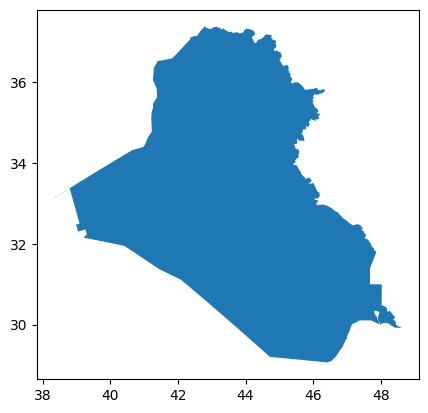

In [19]:
irq_adm0.plot()

/tmp/ipykernel_241/1290787813.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


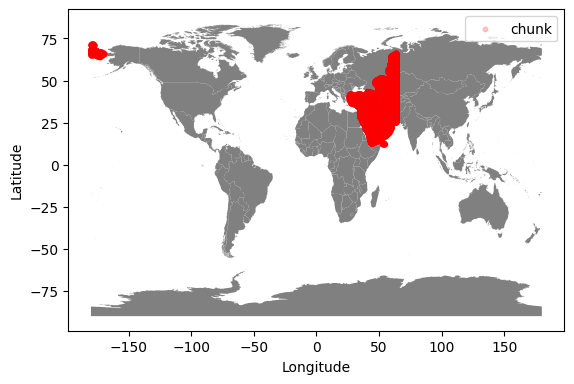

In [23]:
# Create a matplotlib figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame on the axis
geom_adm0.plot(ax=ax, color='grey', label='Earth')

# Plot the second GeoDataFrame on top of the first one
chunk1.plot(ax=ax, color='red', marker='o', markersize=10, label='chunk', alpha=0.2)

# Set axis labels and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()

In [35]:
points_within_polygon = gpd.sjoin(chunk1, irq_adm0, op='within')
points_within_polygon.shape

/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


(4217, 10)

In [46]:
range(39007)

range(0, 39007)

In [47]:
points_within_polygon.index

Index([13213, 13214, 13401, 13402, 13403, 13404, 13405, 13406, 13590, 13591,
       ...
       38135, 38136, 38137, 38429, 38430, 38431, 38720, 38721, 38722, 39006],
      dtype='int64', length=4217)

In [59]:
tot_rows = points_within_polygon.shape[0]
tot_rows

4217

In [56]:
skip_rows = [i+1 for i in range(39007) if i not in points_within_polygon.index]

In [55]:
skip_rows

TypeError: can only concatenate list (not "int") to list

In [ ]:
skip_rows = [1, 3, 5]  # Example: Skip rows 1, 3, and 5


In [41]:
# points_within_polygon[['lon', 'lat']].to_csv('../data/interim/geom_irq_01x01.csv', index=False)

In [57]:
df = pd.read_csv(f'{path_data}/{path_chunk1}', skiprows=lambda x: x in skip_rows, nrows=tot_rows)


In [63]:
df.to_csv('../data/interim/mosaiks_irq_01x01.csv', index=False)

In [64]:
# Create a matplotlib figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame on the axis
irq_adm0.plot(ax=ax, color='grey', label='Earth')

# Plot the second GeoDataFrame on top of the first one
df.plot(ax=ax, color='red', marker='o', markersize=10, label='chunk', alpha=0.2)

# Set axis labels and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()


/tmp/ipykernel_241/488110464.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


ValueError: Image size of 562x84418 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [11]:
bounds = irq_adm0['geometry'].geometry.total_bounds

In [57]:
# Create a square grid within Iraq's bounding box
num_rows = 3
num_cols = 4

# Calculate the width and height of each grid cell
grid_width = (bounds[2] - bounds[0]) / num_cols
grid_height = (bounds[3] - bounds[1]) / num_rows

# Create a list to store the grid polygons
grid_polygons = []

# Generate the grid polygons
for i in range(num_rows):
    for j in range(num_cols):
        xmin = bounds[0] + j * grid_width
        xmax = xmin + grid_width
        ymin = bounds[1] + i * grid_height
        ymax = ymin + grid_height

        grid_polygon = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
        grid_polygons.append(grid_polygon)


# Create a GeoDataFrame from the grid polygons
grid_gdf = gpd.GeoDataFrame({'geometry': grid_polygons})

# Filter grid polygons that intersect with Iraq
intersecting_grid_gdf = grid_gdf[grid_gdf.intersects(irq_adm0['geometry'].geometry.unary_union)]
intersecting_grid_gdf.reset_index(inplace= True, drop=True)

intersecting_grid_gdf.shape

(11, 1)

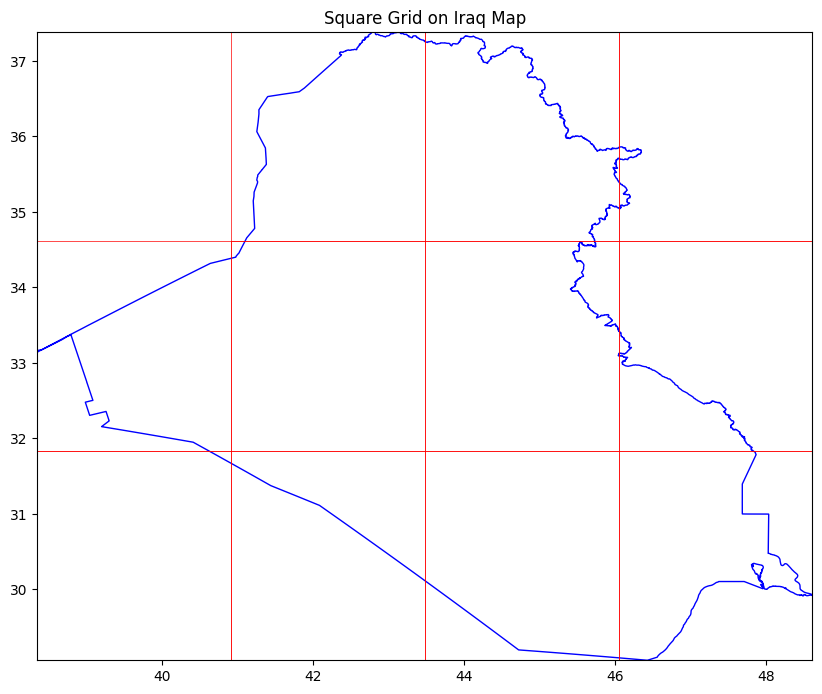

In [58]:
# Plot the map with the grid overlay
fig, ax = plt.subplots(figsize=(10, 10))
irq_adm0['geometry'].geometry.boundary.plot(ax=ax, linewidth=1, color='blue')
intersecting_grid_gdf.boundary.plot(ax=ax, linewidth=0.5, color='red')

# Set axis limits to focus on Iraq
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

plt.title("Square Grid on Iraq Map")
plt.show()


In [60]:
# Create empty lists to store the calculated values
min_lon_list = []
max_lon_list = []
min_lat_list = []
max_lat_list = []

# Iterate through the intersecting grid polygons and calculate the values
for polygon in intersecting_grid_gdf['geometry']:
    min_lon, min_lat, max_lon, max_lat = polygon.bounds
    min_lon_list.append(min_lon)
    max_lon_list.append(max_lon)
    min_lat_list.append(min_lat)
    max_lat_list.append(max_lat)

# Add these lists as new columns to the GeoDataFrame
intersecting_grid_gdf['min_lat'] = min_lat_list
intersecting_grid_gdf['max_lat'] = max_lat_list
intersecting_grid_gdf['min_lon'] = min_lon_list
intersecting_grid_gdf['max_lon'] = max_lon_list

# Display the GeoDataFrame with the new columns
intersecting_grid_gdf

/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry,min_lat,max_lat,min_lon,max_lon
0,"POLYGON ((38.35053 29.06121, 40.91545 29.06121...",29.061210,31.834320,38.350531,40.915447
1,"POLYGON ((40.91545 29.06121, 43.48036 29.06121...",29.061210,31.834320,40.915447,43.480362
2,"POLYGON ((43.48036 29.06121, 46.04528 29.06121...",29.061210,31.834320,43.480362,46.045277
3,"POLYGON ((46.04528 29.06121, 48.61019 29.06121...",29.061210,31.834320,46.045277,48.610193
4,"POLYGON ((38.35053 31.83432, 40.91545 31.83432...",31.834320,34.607429,38.350531,40.915447
5,"POLYGON ((40.91545 31.83432, 43.48036 31.83432...",31.834320,34.607429,40.915447,43.480362
6,"POLYGON ((43.48036 31.83432, 46.04528 31.83432...",31.834320,34.607429,43.480362,46.045277
7,"POLYGON ((46.04528 31.83432, 48.61019 31.83432...",31.834320,34.607429,46.045277,48.610193
8,"POLYGON ((40.91545 34.60743, 43.48036 34.60743...",34.607429,37.380539,40.915447,43.480362
9,"POLYGON ((43.48036 34.60743, 46.04528 34.60743...",34.607429,37.380539,43.480362,46.045277


In [27]:
print(intersecting_grid_gdf.iloc[0]

geometry    POLYGON ((42.45440 29.06121, 44.50633 29.06121...
Name: 2, dtype: geometry
